In [ ]:
# расскоментируйте код ниже, чтобы установить все зависимости
# !pip install -q \
#     pyarrow==12.0.1 \
#     polars==0.18.6 \
#     pandas==2.0.3 \
#     scipy==1.10.1 \
#     numpy==1.24.3 \
#     torch==2.0.1

In [1]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import polars as pl
import scipy.sparse as sp

import time
from typing import List
import matplotlib.pyplot as plt

Pytorch – фреймворк глубокого обучения, позволяющий использовать autograd (автоматический подсчет градиента с помощью обратного распространения ошибки) для простого и эффективного построения глубоких моделей

Работа с данными выполнена в максимально похожем на numpy array стиле, а для ускорения обучения моделей можно легко использовать gpu с минимальными изменениями в коде

In [2]:
x_numpy = np.array([1, 2, 3])
print(x_numpy)

[1 2 3]


In [3]:
x_torch = torch.from_numpy(x_numpy)
print(x_torch)

tensor([1, 2, 3])


In [4]:
x_torch.requires_grad

False

In [5]:
x_torch = x_torch.float()
x_torch.requires_grad = True
x_torch.requires_grad

True

Давайте зададим простую функцию, которую мы хотим приблизить с помощью глубокой модели:

$f(x) = 3 \cdot \cos(x^2 + \sqrt{|x|}) + 5 + x^3 + \epsilon$, где $\epsilon$ – случайная величина (шум) из стандартного нормального распределения

In [6]:
def f(x):
    return 3 * torch.cos(x**2 + torch.sqrt(torch.abs(x))) + 5 + x**3 + torch.randn_like(x)

x_all = torch.from_numpy(np.random.uniform(-10, 10, size=1_000)).float()
x_all = torch.sort(x_all)[0]

x_train = x_all[:900]
y_train = f(x_train)

x_test = x_all[900:]
y_test = f(x_test)

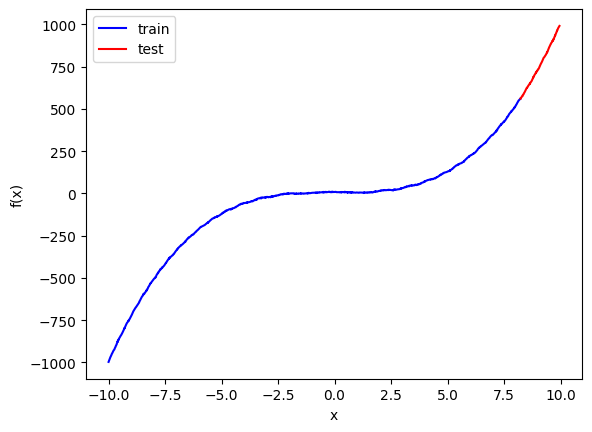

In [7]:
plt.plot(x_train, y_train, c='b', label='train')
plt.plot(x_test, y_test, c='r', label='test')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show();

## Обучим простую модель

`nn.Module` – базовый класс для имплементации глубоких моделей

`torch.optim.*` – различные варианты оптимизаторов, мы будем использовать Adam как наиболее универсальный

`nn.MSELoss` – функция ошибки MSE (можно делать и свои собственные функции, которые состоят из функций pytorch)

`nn.Linear` – линейный полносвязный слой  (матрица n x m и параметр глобального смещения)

`nn.ReLU` – функция активации `relu(x) = min(0, x)`

In [8]:
class PredictionModel(nn.Module):
    def __init__(
        self,
        n_blocks: int = 3,
        hidden_dim: int = 64,
        input_dim: int = 1,
        output_dim: int = 1,
    ):
        # важно сделать, чтобы слои учитывались при обратном распространении ошибок
        super().__init__()

        # наша сеть будет состоять из скрытых блоков вида [Liner, ReLU], а также входной и выходной слой
        layers = []
        layers.extend(
            [
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU(),
            ]
        )
        for _ in range(n_blocks):
            layers.extend([nn.Linear(hidden_dim, hidden_dim), nn.ReLU()])
        layers.extend([nn.Linear(hidden_dim, output_dim)])
        self.ff_layers = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.ff_layers(x)
        return x

In [9]:
%%time

model = PredictionModel()
# в качестве параметров оптимизатору передаем параметры нашей модели
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
# в качестве функции ошибки используем MSE, так как решаем задачу регрессии
criterion = nn.MSELoss()

n_epochs = 1000

for epoch in range(n_epochs):
    # включим режим обучения
    model.train()
    
    # обнулим все градиенты, чтобы делать градиентный спуск только по текущим данным
    optimizer.zero_grad()
    
    y_preds = model(x_train.unsqueeze(-1))
    train_loss = criterion(y_preds, y_train.unsqueeze(-1))
    
    # сделаем обратное распространение ошибки
    train_loss.backward()
    # и шаг градиентного спуска с помощью оптимизатора
    optimizer.step()
    
    # включим режим инференса
    model.eval()
    
    # режим no_grad отключает подсчет градиентов
    with torch.no_grad():
        y_preds = model(x_test.unsqueeze(-1)).squeeze(-1)
    
    test_loss = criterion(y_preds, y_test)
    
    print(f'[{epoch + 1}/{n_epochs} epoch] Train loss = {train_loss:.2f}, Test loss = {test_loss:.2f}')

[1/1000 epoch] Train loss = 108642.52, Test loss = 601753.00
[2/1000 epoch] Train loss = 108266.81, Test loss = 600409.06
[3/1000 epoch] Train loss = 107459.36, Test loss = 598142.19
[4/1000 epoch] Train loss = 105852.34, Test loss = 594116.25
[5/1000 epoch] Train loss = 102997.92, Test loss = 587348.88
[6/1000 epoch] Train loss = 98417.16, Test loss = 576594.62
[7/1000 epoch] Train loss = 91279.86, Test loss = 560314.81
[8/1000 epoch] Train loss = 81157.51, Test loss = 536642.19
[9/1000 epoch] Train loss = 67725.43, Test loss = 503408.72
[10/1000 epoch] Train loss = 51578.71, Test loss = 458806.84
[11/1000 epoch] Train loss = 35411.03, Test loss = 400389.69
[12/1000 epoch] Train loss = 25585.08, Test loss = 327777.03
[13/1000 epoch] Train loss = 32235.96, Test loss = 241843.31
[14/1000 epoch] Train loss = 36826.93, Test loss = 148751.20
[15/1000 epoch] Train loss = 29401.55, Test loss = 73574.52
[16/1000 epoch] Train loss = 23125.53, Test loss = 45532.52
[17/1000 epoch] Train loss = 2

[150/1000 epoch] Train loss = 76.68, Test loss = 20452.83
[151/1000 epoch] Train loss = 69.50, Test loss = 20181.18
[152/1000 epoch] Train loss = 69.78, Test loss = 19596.08
[153/1000 epoch] Train loss = 72.68, Test loss = 19662.78
[154/1000 epoch] Train loss = 70.95, Test loss = 19355.51
[155/1000 epoch] Train loss = 64.64, Test loss = 19229.75
[156/1000 epoch] Train loss = 58.13, Test loss = 18891.31
[157/1000 epoch] Train loss = 55.93, Test loss = 18599.62
[158/1000 epoch] Train loss = 57.01, Test loss = 18673.88
[159/1000 epoch] Train loss = 57.86, Test loss = 18215.38
[160/1000 epoch] Train loss = 55.97, Test loss = 18105.08
[161/1000 epoch] Train loss = 51.98, Test loss = 17837.44
[162/1000 epoch] Train loss = 48.26, Test loss = 17752.38
[163/1000 epoch] Train loss = 46.54, Test loss = 17601.42
[164/1000 epoch] Train loss = 46.53, Test loss = 17253.92
[165/1000 epoch] Train loss = 47.04, Test loss = 17300.80
[166/1000 epoch] Train loss = 46.75, Test loss = 17025.49
[167/1000 epoc

[321/1000 epoch] Train loss = 56.68, Test loss = 12801.42
[322/1000 epoch] Train loss = 80.87, Test loss = 11285.10
[323/1000 epoch] Train loss = 119.24, Test loss = 13147.50
[324/1000 epoch] Train loss = 150.97, Test loss = 11106.95
[325/1000 epoch] Train loss = 179.43, Test loss = 13209.88
[326/1000 epoch] Train loss = 153.28, Test loss = 11400.67
[327/1000 epoch] Train loss = 98.71, Test loss = 12629.26
[328/1000 epoch] Train loss = 34.04, Test loss = 12224.66
[329/1000 epoch] Train loss = 10.49, Test loss = 11868.99
[330/1000 epoch] Train loss = 33.71, Test loss = 13013.24
[331/1000 epoch] Train loss = 69.28, Test loss = 11594.33
[332/1000 epoch] Train loss = 81.07, Test loss = 12951.29
[333/1000 epoch] Train loss = 52.86, Test loss = 12061.74
[334/1000 epoch] Train loss = 19.22, Test loss = 12239.84
[335/1000 epoch] Train loss = 12.09, Test loss = 12813.61
[336/1000 epoch] Train loss = 31.20, Test loss = 11848.81
[337/1000 epoch] Train loss = 47.30, Test loss = 12948.07
[338/1000 

[492/1000 epoch] Train loss = 7.52, Test loss = 12241.68
[493/1000 epoch] Train loss = 7.52, Test loss = 12288.30
[494/1000 epoch] Train loss = 7.52, Test loss = 12220.46
[495/1000 epoch] Train loss = 7.52, Test loss = 12278.97
[496/1000 epoch] Train loss = 7.52, Test loss = 12202.70
[497/1000 epoch] Train loss = 7.51, Test loss = 12268.40
[498/1000 epoch] Train loss = 7.51, Test loss = 12181.54
[499/1000 epoch] Train loss = 7.52, Test loss = 12258.70
[500/1000 epoch] Train loss = 7.53, Test loss = 12150.39
[501/1000 epoch] Train loss = 7.56, Test loss = 12253.43
[502/1000 epoch] Train loss = 7.62, Test loss = 12110.74
[503/1000 epoch] Train loss = 7.72, Test loss = 12259.30
[504/1000 epoch] Train loss = 7.90, Test loss = 12060.39
[505/1000 epoch] Train loss = 8.19, Test loss = 12283.48
[506/1000 epoch] Train loss = 8.67, Test loss = 11989.18
[507/1000 epoch] Train loss = 9.51, Test loss = 12340.23
[508/1000 epoch] Train loss = 10.92, Test loss = 11873.51
[509/1000 epoch] Train loss = 

[666/1000 epoch] Train loss = 7.01, Test loss = 12190.62
[667/1000 epoch] Train loss = 7.63, Test loss = 11951.11
[668/1000 epoch] Train loss = 8.77, Test loss = 12259.91
[669/1000 epoch] Train loss = 10.71, Test loss = 11838.09
[670/1000 epoch] Train loss = 14.38, Test loss = 12399.19
[671/1000 epoch] Train loss = 20.52, Test loss = 11647.32
[672/1000 epoch] Train loss = 32.53, Test loss = 12661.78
[673/1000 epoch] Train loss = 51.87, Test loss = 11325.82
[674/1000 epoch] Train loss = 91.81, Test loss = 13160.61
[675/1000 epoch] Train loss = 147.43, Test loss = 10810.04
[676/1000 epoch] Train loss = 260.92, Test loss = 13942.01
[677/1000 epoch] Train loss = 349.80, Test loss = 10368.34
[678/1000 epoch] Train loss = 494.97, Test loss = 14441.25
[679/1000 epoch] Train loss = 379.36, Test loss = 10906.36
[680/1000 epoch] Train loss = 230.85, Test loss = 13377.09
[681/1000 epoch] Train loss = 41.30, Test loss = 13026.42
[682/1000 epoch] Train loss = 31.79, Test loss = 11731.83
[683/1000 e

[834/1000 epoch] Train loss = 242.57, Test loss = 14542.36
[835/1000 epoch] Train loss = 307.34, Test loss = 10843.45
[836/1000 epoch] Train loss = 400.56, Test loss = 14902.25
[837/1000 epoch] Train loss = 312.13, Test loss = 11599.53
[838/1000 epoch] Train loss = 197.12, Test loss = 14161.06
[839/1000 epoch] Train loss = 46.69, Test loss = 13532.50
[840/1000 epoch] Train loss = 15.22, Test loss = 12848.87
[841/1000 epoch] Train loss = 93.35, Test loss = 15400.32
[842/1000 epoch] Train loss = 155.49, Test loss = 12442.92
[843/1000 epoch] Train loss = 144.30, Test loss = 15075.26
[844/1000 epoch] Train loss = 50.40, Test loss = 14290.12
[845/1000 epoch] Train loss = 8.88, Test loss = 13408.28
[846/1000 epoch] Train loss = 47.82, Test loss = 15734.53
[847/1000 epoch] Train loss = 89.71, Test loss = 13413.08
[848/1000 epoch] Train loss = 81.46, Test loss = 14987.35
[849/1000 epoch] Train loss = 27.28, Test loss = 14866.11
[850/1000 epoch] Train loss = 8.89, Test loss = 13724.64
[851/1000

[993/1000 epoch] Train loss = 8.61, Test loss = 14760.70
[994/1000 epoch] Train loss = 57.35, Test loss = 13074.71
[995/1000 epoch] Train loss = 129.99, Test loss = 15789.43
[996/1000 epoch] Train loss = 128.53, Test loss = 13295.61
[997/1000 epoch] Train loss = 84.63, Test loss = 14963.71
[998/1000 epoch] Train loss = 21.00, Test loss = 14837.99
[999/1000 epoch] Train loss = 11.05, Test loss = 13711.88
[1000/1000 epoch] Train loss = 47.98, Test loss = 15691.92
CPU times: user 1.03 s, sys: 663 ms, total: 1.7 s
Wall time: 1.28 s


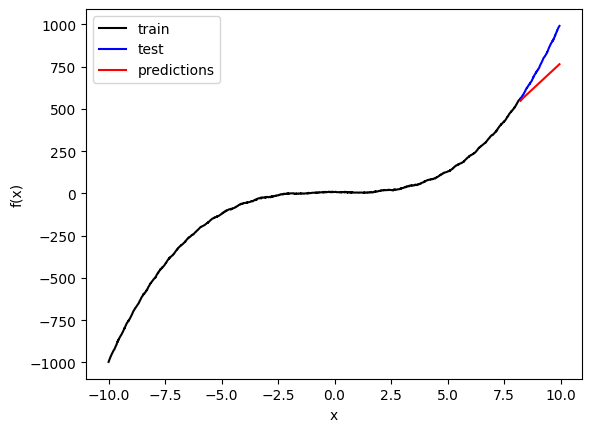

In [10]:
model.eval()

test_ordered_inds = torch.argsort(x_test)
with torch.no_grad():
    y_preds = model(x_test.unsqueeze(-1)).squeeze(-1)

plt.plot(x_train, y_train, c='black', label='train')
plt.plot(x_test, y_test, c='b', label='test')
plt.plot(x_test, y_preds, c='r', label='predictions')

plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()
plt.show();

Как теперь использовать gpu (и не только) для ускорения обучения?

Для этого нужно две вещи:
- перенести модель на девайс `model.to(device)`
- перенести данные на девайс `data.to(device)`

попробуем это применить

In [11]:
device = torch.device('cpu')
if torch.cuda.is_available():
    # если есть gpu с поддержкой cuda
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    # если у вас mac на apple silicon чипе, то тоже можно ускорить
    device = torch.device('mps')
print(f'using {device} device')

using mps device


In [12]:
%%time

model = PredictionModel().to(device)

# в качестве параметров оптимизатору передаем параметры нашей модели
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
# в качестве функции ошибки используем MSE, так как решаем задачу регрессии
criterion = nn.MSELoss()

x_train_device = x_train.unsqueeze(-1).to(device)
x_test_device = x_test.unsqueeze(-1).to(device)

n_epochs = 1000

for epoch in range(n_epochs):
    # включим режим обучения
    model.train()
    
    # обнулим все градиенты, чтобы делать градиентный спуск только по текущим данным
    optimizer.zero_grad()
    
    y_preds = model(x_train_device).cpu()
    train_loss = criterion(y_preds, y_train.unsqueeze(-1))
    
    # сделаем обратное распространение ошибки
    train_loss.backward()
    # и шаг градиентного спуска с помощью оптимизатора
    optimizer.step()
    
    # включим режим инференса
    model.eval()
    
    # режим no_grad отключает подсчет градиентов
    with torch.no_grad():
        y_preds = model(x_test_device).squeeze(-1).cpu()
    
    test_loss = criterion(y_preds, y_test)
    
    print(f'[{epoch + 1}/{n_epochs} epoch] Train loss = {train_loss:.2f}, Test loss = {test_loss:.2f}')

[1/1000 epoch] Train loss = 108655.42, Test loss = 601252.69
[2/1000 epoch] Train loss = 108430.91, Test loss = 598418.50
[3/1000 epoch] Train loss = 107952.32, Test loss = 592693.50
[4/1000 epoch] Train loss = 107019.78, Test loss = 582315.62
[5/1000 epoch] Train loss = 105377.23, Test loss = 564409.38
[6/1000 epoch] Train loss = 102668.73, Test loss = 535655.38
[7/1000 epoch] Train loss = 98501.35, Test loss = 492204.59
[8/1000 epoch] Train loss = 92311.41, Test loss = 430423.62
[9/1000 epoch] Train loss = 83832.25, Test loss = 347260.28
[10/1000 epoch] Train loss = 73067.98, Test loss = 243929.16
[11/1000 epoch] Train loss = 60498.81, Test loss = 129808.48
[12/1000 epoch] Train loss = 48704.29, Test loss = 53712.52
[13/1000 epoch] Train loss = 39863.91, Test loss = 46965.36
[14/1000 epoch] Train loss = 29037.39, Test loss = 76163.04
[15/1000 epoch] Train loss = 19917.18, Test loss = 141662.95
[16/1000 epoch] Train loss = 22505.50, Test loss = 224815.41
[17/1000 epoch] Train loss = 3

[150/1000 epoch] Train loss = 66.02, Test loss = 8362.79
[151/1000 epoch] Train loss = 64.96, Test loss = 9152.94
[152/1000 epoch] Train loss = 60.21, Test loss = 8382.54
[153/1000 epoch] Train loss = 55.67, Test loss = 8967.84
[154/1000 epoch] Train loss = 50.18, Test loss = 8100.34
[155/1000 epoch] Train loss = 46.21, Test loss = 8809.38
[156/1000 epoch] Train loss = 42.83, Test loss = 8107.41
[157/1000 epoch] Train loss = 41.25, Test loss = 8517.28
[158/1000 epoch] Train loss = 40.66, Test loss = 7996.53
[159/1000 epoch] Train loss = 42.27, Test loss = 8587.13
[160/1000 epoch] Train loss = 46.01, Test loss = 7652.83
[161/1000 epoch] Train loss = 55.25, Test loss = 8706.44
[162/1000 epoch] Train loss = 71.95, Test loss = 7317.13
[163/1000 epoch] Train loss = 107.04, Test loss = 8981.49
[164/1000 epoch] Train loss = 160.10, Test loss = 6732.28
[165/1000 epoch] Train loss = 252.58, Test loss = 9657.24
[166/1000 epoch] Train loss = 329.45, Test loss = 6315.02
[167/1000 epoch] Train loss

[300/1000 epoch] Train loss = 165.90, Test loss = 8174.59
[301/1000 epoch] Train loss = 181.75, Test loss = 5578.24
[302/1000 epoch] Train loss = 200.54, Test loss = 8182.85
[303/1000 epoch] Train loss = 165.15, Test loss = 5821.57
[304/1000 epoch] Train loss = 116.62, Test loss = 7515.50
[305/1000 epoch] Train loss = 51.50, Test loss = 6645.35
[306/1000 epoch] Train loss = 16.89, Test loss = 6561.08
[307/1000 epoch] Train loss = 21.87, Test loss = 7592.57
[308/1000 epoch] Train loss = 51.97, Test loss = 6104.35
[309/1000 epoch] Train loss = 81.90, Test loss = 7753.22
[310/1000 epoch] Train loss = 83.22, Test loss = 6239.78
[311/1000 epoch] Train loss = 63.86, Test loss = 7253.87
[312/1000 epoch] Train loss = 32.62, Test loss = 6724.61
[313/1000 epoch] Train loss = 15.10, Test loss = 6665.00
[314/1000 epoch] Train loss = 19.38, Test loss = 7336.54
[315/1000 epoch] Train loss = 35.60, Test loss = 6333.64
[316/1000 epoch] Train loss = 47.10, Test loss = 7544.00
[317/1000 epoch] Train los

[473/1000 epoch] Train loss = 12.77, Test loss = 7382.58
[474/1000 epoch] Train loss = 11.97, Test loss = 7381.80
[475/1000 epoch] Train loss = 11.47, Test loss = 7352.10
[476/1000 epoch] Train loss = 11.75, Test loss = 7426.15
[477/1000 epoch] Train loss = 12.16, Test loss = 7313.61
[478/1000 epoch] Train loss = 12.06, Test loss = 7473.06
[479/1000 epoch] Train loss = 11.57, Test loss = 7338.33
[480/1000 epoch] Train loss = 11.26, Test loss = 7374.77
[481/1000 epoch] Train loss = 11.36, Test loss = 7468.66
[482/1000 epoch] Train loss = 11.59, Test loss = 7265.75
[483/1000 epoch] Train loss = 11.60, Test loss = 7459.21
[484/1000 epoch] Train loss = 11.32, Test loss = 7340.53
[485/1000 epoch] Train loss = 11.05, Test loss = 7309.91
[486/1000 epoch] Train loss = 11.03, Test loss = 7433.93
[487/1000 epoch] Train loss = 11.15, Test loss = 7273.98
[488/1000 epoch] Train loss = 11.22, Test loss = 7389.70
[489/1000 epoch] Train loss = 11.11, Test loss = 7346.83
[490/1000 epoch] Train loss = 1

[621/1000 epoch] Train loss = 10.75, Test loss = 7577.32
[622/1000 epoch] Train loss = 11.73, Test loss = 7660.50
[623/1000 epoch] Train loss = 12.13, Test loss = 7538.10
[624/1000 epoch] Train loss = 11.42, Test loss = 7694.87
[625/1000 epoch] Train loss = 10.55, Test loss = 7556.81
[626/1000 epoch] Train loss = 10.47, Test loss = 7561.45
[627/1000 epoch] Train loss = 10.99, Test loss = 7727.90
[628/1000 epoch] Train loss = 11.29, Test loss = 7438.21
[629/1000 epoch] Train loss = 10.98, Test loss = 7684.18
[630/1000 epoch] Train loss = 10.41, Test loss = 7580.92
[631/1000 epoch] Train loss = 10.19, Test loss = 7457.00
[632/1000 epoch] Train loss = 10.43, Test loss = 7675.61
[633/1000 epoch] Train loss = 10.69, Test loss = 7425.91
[634/1000 epoch] Train loss = 10.63, Test loss = 7529.16
[635/1000 epoch] Train loss = 10.31, Test loss = 7517.26
[636/1000 epoch] Train loss = 10.05, Test loss = 7420.27
[637/1000 epoch] Train loss = 10.03, Test loss = 7506.67
[638/1000 epoch] Train loss = 1

[800/1000 epoch] Train loss = 7.98, Test loss = 6764.31
[801/1000 epoch] Train loss = 7.95, Test loss = 6782.10
[802/1000 epoch] Train loss = 7.92, Test loss = 6720.71
[803/1000 epoch] Train loss = 7.90, Test loss = 6775.35
[804/1000 epoch] Train loss = 7.88, Test loss = 6761.42
[805/1000 epoch] Train loss = 7.87, Test loss = 6719.56
[806/1000 epoch] Train loss = 7.86, Test loss = 6775.65
[807/1000 epoch] Train loss = 7.84, Test loss = 6732.14
[808/1000 epoch] Train loss = 7.83, Test loss = 6728.89
[809/1000 epoch] Train loss = 7.82, Test loss = 6744.49
[810/1000 epoch] Train loss = 7.81, Test loss = 6729.12
[811/1000 epoch] Train loss = 7.79, Test loss = 6703.69
[812/1000 epoch] Train loss = 7.77, Test loss = 6745.85
[813/1000 epoch] Train loss = 7.76, Test loss = 6697.87
[814/1000 epoch] Train loss = 7.74, Test loss = 6713.96
[815/1000 epoch] Train loss = 7.72, Test loss = 6721.17
[816/1000 epoch] Train loss = 7.71, Test loss = 6697.37
[817/1000 epoch] Train loss = 7.69, Test loss = 

[977/1000 epoch] Train loss = 7.05, Test loss = 6200.31
[978/1000 epoch] Train loss = 7.18, Test loss = 6348.44
[979/1000 epoch] Train loss = 7.39, Test loss = 6153.57
[980/1000 epoch] Train loss = 7.72, Test loss = 6388.15
[981/1000 epoch] Train loss = 8.22, Test loss = 6088.55
[982/1000 epoch] Train loss = 9.05, Test loss = 6451.18
[983/1000 epoch] Train loss = 10.35, Test loss = 6004.03
[984/1000 epoch] Train loss = 12.56, Test loss = 6550.48
[985/1000 epoch] Train loss = 15.98, Test loss = 5862.42
[986/1000 epoch] Train loss = 22.15, Test loss = 6747.00
[987/1000 epoch] Train loss = 31.50, Test loss = 5609.88
[988/1000 epoch] Train loss = 49.27, Test loss = 7118.19
[989/1000 epoch] Train loss = 74.46, Test loss = 5205.50
[990/1000 epoch] Train loss = 125.25, Test loss = 7773.97
[991/1000 epoch] Train loss = 183.43, Test loss = 4628.98
[992/1000 epoch] Train loss = 306.20, Test loss = 8790.74
[993/1000 epoch] Train loss = 356.74, Test loss = 4094.54
[994/1000 epoch] Train loss = 477

Используя mps получилось еще дольше, как думаете, почему?

## Попробуем реализовать модель SLIM

**Важно**: это не является оригинальным алгоритмом, так как не требуется положительная определнность матрицы весов

In [ ]:
# раскоментируйте следующие строчки, чтобы загрузить датасет
# !wget -q https://files.grouplens.org/datasets/movielens/ml-1m.zip
# !unzip -q ml-1m.zip

In [14]:
ratings = pd.read_csv(
    'ml-1m/ratings.dat', delimiter='::', header=None, 
    names=['user_id', 'item_id', 'rating', 'timestamp'], 
    engine='python'
)
ratings = pl.from_pandas(ratings).filter(pl.col('rating') >= 4)
ratings

user_id,item_id,rating,timestamp
i64,i64,i64,i64
1,1193,5,978300760
1,3408,4,978300275
1,2355,5,978824291
1,1287,5,978302039
1,2804,5,978300719
1,594,4,978302268
1,919,4,978301368
1,595,5,978824268
1,938,4,978301752


In [15]:
grouped_df = (
    ratings
    .groupby('user_id')
    .agg([
        pl.col('item_id').apply(lambda x: x[:-3]).alias('train_item_ids'),
        pl.col('rating').apply(lambda x: x[:-3]).alias('train_ratings'),
        pl.col('item_id').apply(lambda x: x[-3:]).alias('test_item_ids'),
        pl.col('rating').apply(lambda x: x[-3:]).alias('test_ratings'),
    ])
)
grouped_df

user_id,train_item_ids,train_ratings,test_item_ids,test_ratings
i64,list[i64],list[i64],list[i64],list[i64]
2144,"[1258, 1407, … 1986]","[4, 5, … 4]","[70, 2959, 1222]","[4, 4, 4]"
1248,"[1256, 1259, … 3911]","[5, 5, … 5]","[1238, 3925, 1242]","[5, 4, 4]"
1408,"[1258, 589, … 555]","[5, 4, … 4]","[556, 99, 1233]","[5, 5, 4]"
1376,"[2987, 2997, … 1213]","[4, 4, … 4]","[2975, 1093, 1094]","[4, 4, 4]"
784,"[2987, 1617, … 507]","[5, 5, … 4]","[3753, 2959, 2979]","[5, 5, 4]"
560,"[2993, 2058, … 95]","[5, 5, … 4]","[1233, 1240, 2985]","[5, 4, 4]"
2776,"[719, 3791, … 1095]","[4, 5, … 4]","[1097, 1242, 1246]","[5, 4, 5]"
4544,"[3789, 908, … 2731]","[4, 5, … 4]","[3742, 1095, 3788]","[4, 5, 5]"
4552,"[2058, 589, … 527]","[4, 5, … 5]","[3744, 534, 2028]","[4, 4, 5]"


In [16]:
median_seq_len = int(grouped_df['train_item_ids'].apply(len).median())
print(f"средняя длина сессии {median_seq_len}")

средняя длина сессии 55


In [17]:
TOP_K = 10


def user_intersection(y_relevant: List[str], y_recs: List[str], k: int = TOP_K) -> int:
    return len(set(y_relevant).intersection(y_recs[:k]))


def user_hitrate(y_relevant: List[str], y_recs: List[str], k: int = TOP_K) -> int:
    return int(user_intersection(y_relevant, y_recs, k) > 0)

In [18]:
# соберем строчки для разреженной матрицы
rows = []
cols = []
values = []

for user_id, train_item_ids, train_ratings in grouped_df.select(
    'user_id', 'train_item_ids', 'train_ratings'
).rows():
    rows.extend([user_id] * len(train_item_ids))
    cols.extend(train_item_ids)
    values.extend(train_ratings)

user_item_data = sp.csr_matrix((values, (rows, cols)), dtype=np.float32)
user_item_data

<6041x3953 sparse matrix of type '<class 'numpy.float32'>'
	with 557171 stored elements in Compressed Sparse Row format>

преобразуем scipy разреженную матрицу в pytorch разреженную матрицу

In [19]:
user_item_data_coo = user_item_data.tocoo()

values = user_item_data_coo.data
indices = np.vstack((user_item_data_coo.row, user_item_data_coo.col))

i = torch.LongTensor(indices)
v = torch.FloatTensor(values)
shape = user_item_data_coo.shape

R = torch.sparse.FloatTensor(i, v, torch.Size(shape))
R

tensor(indices=tensor([[   1,    1,    1,  ..., 6040, 6040, 6040],
                       [   1,   48,  150,  ..., 3735, 3751, 3819]]),
       values=tensor([5., 5., 5.,  ..., 4., 4., 5.]),
       size=(6041, 3953), nnz=557171, layout=torch.sparse_coo)

In [20]:
class SLIM(nn.Module):
    def __init__(self, R: torch.Tensor):
        super().__init__()
        
        _, n = R.shape
        self.R = R
        # проинициализируем матрицу W нулями
        self.W = torch.zeros(n, n)
        # дадим знать pytorch, что для этой матрицы нужно посчитать градиент
        self.W.requires_grad = True
        # будем использовать маску, чтобы элементы по диагонали никак не участвовали в обучении
        self.mask = 1 - torch.eye(n)
    
    def forward(self, x):
        W_masked = self.W * self.mask
        return self.R @ W_masked

In [41]:
beta = 5
alpha = 1
n_epochs = 100

model = SLIM(R)
# здесь явно укажем, что в качестве обучаемых параметров будет матрица W
optimizer = torch.optim.Adam([model.W], lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)

for epoch in range(n_epochs):
    optimizer.zero_grad()
    y_pred = model(R)
    # наша функция ошибки состоит из MSE, L2 и L1 регуляризации
    loss = (
        torch.sum((y_pred - R) ** 2) / 2
        + beta / 2 * (model.W**2).sum()
        + alpha * model.W.abs().sum()
    )

    loss.backward()
    optimizer.step()

    # с помощью функции topk выберем индексы top-k максимальных объектов на основе предсказанной матрицы рейтингов
    recs = torch.topk(y_pred, TOP_K + median_seq_len)[1].numpy()

    # оценим метрику качества самих рекомендаций
    hitrate_list = []
    for user_id, user_history, y_rel in grouped_df.select(
        "user_id", "train_item_ids", "test_item_ids"
    ).rows():
        user_history = set(user_history)
        y_rec = [item_id for item_id in recs[user_id] if item_id not in user_history]
        hitrate_list.append(user_hitrate(y_rel, y_rec))

    mean_hitrate = np.mean(hitrate_list)

    print(f"[{epoch} epoch]\tLoss = {loss.item()}, Hitrate@{TOP_K} = {mean_hitrate}")

[0 epoch]	Loss = 5440163.5, Hitrate@10 = 0.0
[1 epoch]	Loss = 6328567.0, Hitrate@10 = 0.01159324279562769
[2 epoch]	Loss = 4658681.5, Hitrate@10 = 0.13895329579330903
[3 epoch]	Loss = 4830916.5, Hitrate@10 = 0.14027823782709506
[4 epoch]	Loss = 5078073.0, Hitrate@10 = 0.14491553494534615
[5 epoch]	Loss = 4548290.0, Hitrate@10 = 0.1467373302418019
[6 epoch]	Loss = 3988636.75, Hitrate@10 = 0.15071215634316
[7 epoch]	Loss = 3921618.25, Hitrate@10 = 0.15336204041073204
[8 epoch]	Loss = 4114344.75, Hitrate@10 = 0.16098045710500167
[9 epoch]	Loss = 4077572.5, Hitrate@10 = 0.17025505134150382
[10 epoch]	Loss = 3775872.75, Hitrate@10 = 0.17737661477310368
[11 epoch]	Loss = 3508397.25, Hitrate@10 = 0.1825107651540245
[12 epoch]	Loss = 3465091.75, Hitrate@10 = 0.18648559125538258
[13 epoch]	Loss = 3545176.25, Hitrate@10 = 0.1878105332891686
[14 epoch]	Loss = 3537846.5, Hitrate@10 = 0.19261344816164294
[15 epoch]	Loss = 3392435.25, Hitrate@10 = 0.2007287181185823
[16 epoch]	Loss = 3228467.5, Hitr

После 22 эпохи моделька начала переобучаться, но тем не менее мы достигли результат SVD 🥳